In [13]:
# here we're going to just try writing something from scratch
# do single lith for starters

In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [57]:
# set up arrays
dx = 1000
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

Hstar = 0.5
etab = np.zeros(len(x)) # bedrock elevation, m
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x))
eta = etab + H

In [58]:
# set up parameters
K_ig = np.zeros(len(x))
K_ig[:14] = 1e-8
K_sed = np.zeros(len(x))
K_sed[14:] = 1e-7

beta_ig = np.zeros(len(x))
beta_ig[:14] = 4e-6
beta_sed = np.zeros(len(x))
beta_sed[14:] = 4e-4

psi = 4e-6

r = 10 # runoff rate
D = 0.03 # grain size
phi = 0.45 # porosity
baselevel_rate = 0.0001 # baselevel fall rate

In [59]:
kqs = 0.041
I = 0.01
kxb = 25
Pxb = 1./5.

B = kxb * (x_node**Pxb)

Q = r * x * B

In [60]:
len(eta)

50

In [61]:
def model(x, dx, x_node,
          K_ig, K_sed, beta_ig, beta_sed,
          D, phi, Hstar, psi,
          kqs, I, r, B, Q,
          etab, H, eta,
          baselevel_rate,
          num_steps = 1):
    
    q = Q/B
    dt = 0.2 * dx * dx / (kqs * q[-1])
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p_ig = np.zeros(len(x))
    Eb_p_sed = np.zeros(len(x))
    Eb_a_ig = np.zeros(len(x))
    Eb_a_sed = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    
    H[-1] = 0
    E[-1] = baselevel_rate
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= baselevel_rate * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B[1:]
        
        # calc bedrock erosion
        Eb_p_ig[:-1] = K_ig[1:] * q[1:] * S * alpha[:-1]
        Eb_p_sed[:-1] = K_sed[1:] * q[1:] * S * alpha[:-1]
        Eb_a_ig[:-1] = beta_ig[1:] * qs[1:] * alpha[:-1]
        Eb_a_sed[:-1] = beta_sed[1:] * qs[1:] * alpha[:-1]
        Eb[:-1] = Eb_p_ig[:-1] + Eb_p_sed[:-1] + Eb_a_ig[:-1] + Eb_a_sed[:-1] 
        
        # calc grain attrition
        atr = Qs * psi
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B[:-1]) * (np.diff(Qs)/dx + atr[1:] - (Eb_p_ig[:-1] * B[:-1]))
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p_ig, Eb_p_sed, Eb_a_ig, Eb_a_sed, Eb, atr, Eh, E, etab, H, eta)

In [67]:
#now write a test
num_steps = 5000000
test_run = [x, dx, x_node, 
            K_ig, K_sed, beta_ig, beta_sed, 
            D, phi, Hstar, psi,
            kqs, I, r, B, Q,
            etab, H, eta,
            baselevel_rate,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p_ig, Eb_p_sed, Eb_a_ig, Eb_a_sed, Eb, atr, Eh, E, etab, H, eta) = model(*test_run)

49776007.96814997


In [68]:
E

array([8.18626583e-05, 9.30515221e-05, 9.55128932e-05, 9.66010090e-05,
       9.72477580e-05, 9.76882842e-05, 9.80132278e-05, 9.82658381e-05,
       9.84696531e-05, 9.86387038e-05, 9.87819341e-05, 9.89053479e-05,
       9.90131445e-05, 9.91083611e-05, 9.91614624e-05, 9.92106774e-05,
       9.92565028e-05, 9.92993464e-05, 9.93395473e-05, 9.93773905e-05,
       9.94131175e-05, 9.94469350e-05, 9.94790211e-05, 9.95095304e-05,
       9.95385977e-05, 9.95663416e-05, 9.95928668e-05, 9.96182661e-05,
       9.96426223e-05, 9.96660095e-05, 9.96884941e-05, 9.97101363e-05,
       9.97309903e-05, 9.97511054e-05, 9.97705265e-05, 9.97892945e-05,
       9.98074469e-05, 9.98250180e-05, 9.98420397e-05, 9.98585409e-05,
       9.98745487e-05, 9.98900880e-05, 9.99051818e-05, 9.99198518e-05,
       9.99341178e-05, 9.99479985e-05, 9.99615113e-05, 9.99746725e-05,
       9.99874973e-05, 1.00000000e-04])

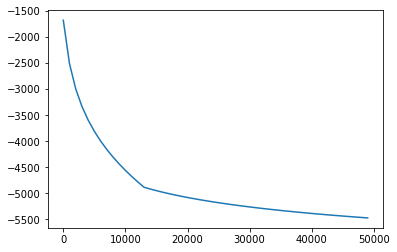

In [69]:
plt.plot(x, eta)

In [70]:
# so far so good!

In [71]:
S

array([0.83247589, 0.48207358, 0.33709378, 0.26157875, 0.21561533,
       0.18477222, 0.16267182, 0.14607278, 0.13315619, 0.12282348,
       0.11437237, 0.10733322, 0.10138019, 0.03392226, 0.03153956,
       0.02945627, 0.02761947, 0.02598803, 0.02452944, 0.02321774,
       0.02203188, 0.02095467, 0.01997189, 0.01907172, 0.0182442 ,
       0.01748093, 0.01677474, 0.01611951, 0.01550993, 0.01494143,
       0.01441002, 0.0139122 , 0.01344492, 0.01300546, 0.01259144,
       0.01220071, 0.0118314 , 0.01148179, 0.01115036, 0.01083575,
       0.01053672, 0.01025215, 0.00998103, 0.00972243, 0.00947552,
       0.00923953, 0.00901376, 0.00879756, 0.00859036])

In [ ]:
# woo! last check - can it handle two liths?
# reverting back to smaller, faster runs to check this

In [ ]:
# call it good

In [72]:
# just for kicks
kb = 8.3e-8
b = (kb * Q[1:] * (S ** (7/6))) / (D**(3/2))
print(b)

[13.9204971  16.30245846 17.23112436 17.97111077 18.66401139 19.34103014
 20.01293968 20.68429983 21.35723586 22.03276652 22.71135781 23.39318239
 24.07825161  7.33336634  7.31406362  7.29446905  7.27462679  7.25457379
  7.23434131  7.21395598  7.1934407   7.17281527  7.15209696  7.13130087
  7.11044031  7.08952705  7.06857156  7.04758315  7.02657018  7.00554017
  6.98449986  6.96345538  6.94241227  6.92137555  6.90034981  6.87933924
  6.85834764  6.83737853  6.81643512  6.79552035  6.77463695  6.75378742
  6.73297406  6.71219901  6.69146424  6.67077157  6.6501227   6.6295192
  6.6089625 ]


In [73]:
# amazing!!

In [74]:
# ok really going out on a limb here...
depth = (0.09801 * D) / S
print(depth)

[0.00353199 0.00609928 0.0087225  0.01124059 0.01363679 0.01591311
 0.01807504 0.02012901 0.02208159 0.02393923 0.02570813 0.02739413
 0.02900271 0.08667761 0.09322577 0.09981916 0.1064575  0.11314057
 0.1198682  0.12664026 0.13345661 0.14031719 0.1472219  0.15417071
 0.16116357 0.16820047 0.17528139 0.18240635 0.18957534 0.1967884
 0.20404554 0.21134681 0.21869226 0.22608191 0.23351584 0.2409941
 0.24851675 0.25608387 0.26369551 0.27135176 0.27905269 0.28679839
 0.29458894 0.30242442 0.31030492 0.31823053 0.32620136 0.33421748
 0.342279  ]


In [ ]:
# okay, so pretty wide relative to depth, but not too shabby